# Hinode SOT/SP Level-1 and Level-2 as NDCube

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import os
import os.path
import sys
import natsort  # Sorting package. Used when I parse the folder for files. There may be simpler ways to do this.

import astropy.units as u
import astropy.wcs
from astropy.coordinates import SkyCoord, SpectralCoord
import astropy.io.fits

import scipy.io

import datetime
import stokespy
import ndcube
from ndcube import NDCube, GlobalCoords, ExtraCoords

# Set working directory. 
work_dir = os.getcwd()

data_dir = work_dir + '/Data/Hinode'

script_name = 'SP_data_loading'

In [1]:
import numpy as np
import os
import natsort  # Sorting package
import astropy.wcs
import astropy.time
import datetime
import sunpy.map
from sunpy.net import Fido, attrs

In [2]:
def get_SP_data(user_date, user_dir=None, show_files=False):
    """
    Function that loads the Hinode SP observations associated with the the string user_date.
    ----------
    user_date: string with format "yearmmdd_hhmmss" specifying the first observation in a scan sequence. 
    user_dir: Directory where the Level1 and Level2 data is located. We assume the data is
    separated into Level1 and Level2 subdirectories. 
    """
    
    ### Set the default directory substructure.
    if user_dir is None:
        user_dir = os.getcwd() + '/Data/Hinode/'
   
    ### Generate the scan file list.
    level1_dir = user_dir + 'Level1/' + user_date
    level1_files = []
    for file in sorted(os.listdir(level1_dir)):
        if not file.endswith(".fits"):
            continue
        level1_files.append(os.path.join(level1_dir, file))
    
    SP_level1 = astropy.io.fits.open(level1_files[0])
    #SP_level1.info()

    ### Read all the Level 1 scan data 
    Nx = len(level1_files)
    Nstokes, Ny, Nwav = SP_level1[0].data.shape
    level1_data = np.zeros((Nx, Nstokes, Ny, Nwav))

    for ix, file in enumerate(level1_files):
        SP_lvl1_obj = astropy.io.fits.open(file)
        level1_data[ix] = SP_lvl1_obj[0].data

    level1_data = level1_data.transpose(1, 3, 2, 0) # data axes order: stokes, wav, y, x
    
    ### Read the Level 2 fit data. 
    level2_fname = user_dir + '/Level2/' + user_date + '.fits'
    SP_level2 = astropy.io.fits.open(level2_fname)
    
    Ny, Nx = SP_level2['Field_Strength'].data.shape
    level2_data = np.zeros((3, Ny, Nx))
    level2_data[0] = SP_level2['Field_Strength'].data
    level2_data[1] = SP_level2['Field_Inclination'].data
    level2_data[2] = SP_level2['Field_Azimuth'].data
    level2_data.shape
    
    ### Build WCS objects.
    head1 = SP_level1['PRIMARY'].header
    head2 = SP_level2['PRIMARY'].header
    
    # NOTE: the data array should be in the opposite order to the WCS, 
    # as numpy arrays are row major and wcses are Cartesian (x, y) ordered.
    # data axes order: stokes, wav, y, x
    # => wcs order   : x, y, wav, stokes
    level1_wcs = astropy.wcs.WCS(naxis=4)
    level1_wcs.wcs.ctype = ["HPLN-TAN", "HPLT-TAN", "WAVE", "STOKES"]
    level1_wcs.wcs.cunit = ['arcsec', 'arcsec', head1['CUNIT1'], '']
    level1_wcs.wcs.crpix = [(head2['NAXIS1']+1)/2, (head2['NAXIS2']+1)/2, head1['CRPIX1'], 0]
    level1_wcs.wcs.crval = [head2['XCEN'], head2['YCEN'], head1['CRVAL1'], 0]
    level1_wcs.wcs.cdelt = [head2['XSCALE'], head2['YSCALE'], head1['CDELT1'], 1]
    level1_wcs.wcs.set()
    
    # NOTE: the data array should be in the opposite order to the WCS, 
    # as numpy arrays are row major and wcses are Cartesian (x, y) ordered.
    # data axes order: |B|, Binc, Bazi, y, x
    # => wcs order   : x, y, Bazi, Binc, |B|
    level2_wcs = astropy.wcs.WCS(naxis=3)
    level2_wcs.wcs.ctype = ["HPLN-TAN", "HPLT-TAN", 'Parameter']
    level2_wcs.wcs.cunit = ['arcsec', 'arcsec', '']
    level2_wcs.wcs.crpix = [(head2['NAXIS1']+1)/2, (head2['NAXIS2']+1)/2, 0]
    level2_wcs.wcs.crval = [head2['XCEN'], head2['YCEN'], 0]
    level2_wcs.wcs.cdelt = [head2['XSCALE'], head2['YSCALE'], 1]
    level2_wcs.wcs.set()
    
    return level1_data, level1_wcs, level2_data, level2_wcs

## Load data using the loader function.



In [3]:
# Select a date and time to search for observations.
#user_date = astropy.time.Time(datetime.datetime(2016, 7, 28, 23, 57, 0), scale='tai')
user_date = '20201101_200602'

# Find the nearest set of Stokes and corresponding inversion results.
#all_fnames_stokes, all_fnames_magvec = get_HMI_data(user_date, user_notify='gdima@hawaii.edu', download=False)
level1_data, level1_wcs, level2_data, level2_wcs = \
    get_SP_data(user_date)

## Load Level-1 Data

In [2]:
user_date = '20201101_200602'

level1_dir = data_dir + '/Level1/' + user_date
level1_files = []
for file in sorted(os.listdir(level1_dir)):
    if not file.endswith(".fits"):
        continue
    level1_files.append(os.path.join(level1_dir, file))

SP_level1 = astropy.io.fits.open(level1_files[0])
SP_level1.info()

Filename: /home/gabriel/Desktop/Science/StokesPY/stokespy_notebooks/Data/Hinode/Level1/20201101_200602/SP3D20201101_200602.0C.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   (112, 512, 4)   int16   
  1                1 NonstandardExtHDU      6   (1536,)      


In [3]:
# Load the quicklook image included with all observations.

QL_fname = level1_dir + '/' + user_date + '_stksimg.save'
data = scipy.io.readsav(QL_fname, python_dict=True, verbose=False)

%matplotlib widget

plt.imshow(data['conti'], origin='lower', interpolation='none')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [1]:
#SP_level1['PRIMARY'].header

In [5]:
SP_level1[0].data.shape

(4, 512, 112)

In [7]:
Nx = len(level1_files)
Nstokes, Ny, Nwav = SP_level1[0].data.shape
level1_data = np.zeros((Nx, Nstokes, Ny, Nwav))

for ix, file in enumerate(level1_files):
    SP_level1 = astropy.io.fits.open(file)
    level1_data[ix] = SP_level1[0].data

level1_data = level1_data.transpose(1, 3, 2, 0) # data axes order: stokes, wav, y, x

In [8]:
level1_data.shape

(4, 112, 512, 1735)

In [9]:
fig, ax = plt.subplots()
stokes = level1_data[0, :, 0, 0]
ax.plot(stokes, 'k-')
ax.set_ylabel('Stokes I')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Stokes I')

In [10]:
# Plot to check how the reconstructed image compares to the
# quicklook image. It seems that the continuum image = 2 * Stokes I data.

%matplotlib widget

fig, axs = plt.subplots(3)
#fig.suptitle('Vertically stacked subplots')

c_wav = 10

axs[0].imshow(2*level1_data[0,c_wav,:,:], origin='lower', interpolation='none')
axs[1].imshow(data['conti'], origin='lower', interpolation='none')
del1 = axs[2].imshow(2*level1_data[0,c_wav,:,:] - data['conti'], origin='lower', 
                     interpolation='none', cmap='bwr', vmin=-400,vmax=400)

plt.colorbar(del1)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Load Level-2 Data

In [11]:
level2_fname = data_dir + '/Level2/' + user_date + '.fits'
SP_level2 = astropy.io.fits.open(level2_fname)

In [12]:
SP_level2.info()

Filename: /home/gabriel/Desktop/Science/StokesPY/stokespy_notebooks/Data/Hinode/Level2/20201101_200602.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  Field_Strength    1 ImageHDU         8   (1735, 512)   float32   
  2  Field_Inclination    1 ImageHDU         8   (1735, 512)   float32   
  3  Field_Azimuth    1 ImageHDU         8   (1735, 512)   float32   
  4  Doppler_Shift1    1 ImageHDU         8   (1735, 512)   float32   
  5  Doppler_Shift2    1 ImageHDU         8   (1735, 512)   float32   
  6  Doppler_Width    1 ImageHDU         8   (1735, 512)   float32   
  7  Line_Strength    1 ImageHDU         8   (1735, 512)   float32   
  8  Damping       1 ImageHDU         8   (1735, 512)   float32   
  9  Source_Function    1 ImageHDU         8   (1735, 512)   float32   
 10  Source_Function_Gradient    1 ImageHDU         8   (1735, 512)   float32   
 11  Macro_Turbulence    1 ImageHDU         8   (1735, 512)   

In [13]:
SP_level2['Primary'].header

SIMPLE  =                    T / Written by IDL:  Sun Dec  6 02:18:11 2020      
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
NAXIS1  =                 1735 /                                                
NAXIS2  =                  512 /                                                
EXTEND  =                    T / File contains extensions                       
XCEN    =             -21.1526 /                                                
YCEN    =              463.854 /                                                
XSCALE  =             0.148572 /                                                
YSCALE  =             0.159990 /                                                
TSTART  = '2020-11-01T20:06:02.039' /                                           
TEND    = '2020-11-01T22:59:30.443' /                                           
MAPID   = '135386  '        

In [14]:
# Demonstrate slit scan discontinuity
pos = SP_level2['Mechanical_Slit_Position'].data[0][0].astype('int')
fig, ax = plt.subplots()
ax.plot(pos)
ax.set_xlabel('index')
ax.set_ylabel('slit position')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'slit position')

In [15]:
Ny, Nx = SP_level2['Field_Strength'].data.shape
level2_data = np.zeros((3, Ny, Nx))
level2_data[0] = SP_level2['Field_Strength'].data
level2_data[1] = SP_level2['Field_Inclination'].data
level2_data[2] = SP_level2['Field_Azimuth'].data
level2_data.shape

(3, 512, 1735)

## Build WCSes

In [16]:
head1 = SP_level1['PRIMARY'].header
head2 = SP_level2['PRIMARY'].header

In [17]:
# NOTE: the data array should be in the opposite order to the WCS, 
# as numpy arrays are row major and wcses are Cartesian (x, y) ordered.
# data axes order: stokes, wav, y, x
# => wcs order   : x, y, wav, stokes
level1_wcs = astropy.wcs.WCS(naxis=4)
level1_wcs.wcs.ctype = ["HPLN-TAN", "HPLT-TAN", "WAVE", "STOKES"]
level1_wcs.wcs.cunit = ['arcsec', 'arcsec', head1['CUNIT1'], '']
level1_wcs.wcs.crpix = [(head2['NAXIS1']+1)/2, (head2['NAXIS2']+1)/2, head1['CRPIX1'], 0]
level1_wcs.wcs.crval = [head2['XCEN'], head2['YCEN'], head1['CRVAL1'], 0]
level1_wcs.wcs.cdelt = [head2['XSCALE'], head2['YSCALE'], head1['CDELT1'], 1]
level1_wcs.wcs.set()
level1_wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
CRVAL : -0.005875722222222222  0.12884833333333334  6.30208e-07  0.0  
CRPIX : 868.0  256.5  56.5  0.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 4.127e-05  4.4441666666666665e-05  2.1549e-12  1.0  
NAXIS : 0  0

In [18]:
# NOTE: the data array should be in the opposite order to the WCS, 
# as numpy arrays are row major and wcses are Cartesian (x, y) ordered.
# data axes order: |B|, Binc, Bazi, y, x
# => wcs order   : x, y, Bazi, Binc, |B|
level2_wcs = astropy.wcs.WCS(naxis=3)
level2_wcs.wcs.ctype = ["HPLN-TAN", "HPLT-TAN", 'Parameter']
level2_wcs.wcs.cunit = ['arcsec', 'arcsec', '']
level2_wcs.wcs.crpix = [(head2['NAXIS1']+1)/2, (head2['NAXIS2']+1)/2, 0]
level2_wcs.wcs.crval = [head2['XCEN'], head2['YCEN'], 0]
level2_wcs.wcs.cdelt = [head2['XSCALE'], head2['YSCALE'], 1]
level2_wcs.wcs.set()
level2_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : -0.005875722222222222  0.12884833333333334  0.0  
CRPIX : 868.0  256.5  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 4.127e-05  4.4441666666666665e-05  1.0  
NAXIS : 0  0

## Build NDCubes

In [4]:
level1_cube = stokespy.StokesCube(level1_data, level1_wcs)

NameError: name 'stokespy' is not defined

In [8]:
# Spectral axis checks out.
print('StokesCube wavelength')
print(level1_cube.spectral_axis)

StokesCube wavelength
[6.30088403e-07 6.30090558e-07 6.30092713e-07 6.30094868e-07
 6.30097023e-07 6.30099178e-07 6.30101332e-07 6.30103487e-07
 6.30105642e-07 6.30107797e-07 6.30109952e-07 6.30112107e-07
 6.30114262e-07 6.30116417e-07 6.30118572e-07 6.30120727e-07
 6.30122881e-07 6.30125036e-07 6.30127191e-07 6.30129346e-07
 6.30131501e-07 6.30133656e-07 6.30135811e-07 6.30137966e-07
 6.30140121e-07 6.30142276e-07 6.30144430e-07 6.30146585e-07
 6.30148740e-07 6.30150895e-07 6.30153050e-07 6.30155205e-07
 6.30157360e-07 6.30159515e-07 6.30161670e-07 6.30163825e-07
 6.30165979e-07 6.30168134e-07 6.30170289e-07 6.30172444e-07
 6.30174599e-07 6.30176754e-07 6.30178909e-07 6.30181064e-07
 6.30183219e-07 6.30185374e-07 6.30187528e-07 6.30189683e-07
 6.30191838e-07 6.30193993e-07 6.30196148e-07 6.30198303e-07
 6.30200458e-07 6.30202613e-07 6.30204768e-07 6.30206923e-07
 6.30209077e-07 6.30211232e-07 6.30213387e-07 6.30215542e-07
 6.30217697e-07 6.30219852e-07 6.30222007e-07 6.30224162e-07
 6

In [9]:
level1_cube.plot()

TODO: implement <class 'stokespy.stokespy.StokesCube'>.plot()


In [10]:
level2_cube = stokespy.MagVectorCube(level2_data, level2_wcs)

In [12]:
# I use jupyter lab which uses this widget command for interactive plotting
#%matplotlib notebook
%matplotlib widget  

mag_map = level2_cube.B
mag_map.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<WCSAxesSubplot:>

## Custom build NDCubes

In [26]:
# Q: Is there introspection for which axis is lat, lon?
# Q: How to make lookup table WCS for level1 only?

In [18]:
level1_cube = ndcube.NDCube(level1_data, level1_wcs)
level2_cube = ndcube.NDCube(level2_data, level2_wcs)

In [19]:
level1_cube

NDCube
------
Dimensions: [   4.  112.  512. 1735.] pix
Physical Types of Axes: [(None,), ('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

In [20]:
level2_cube

NDCube
------
Dimensions: [   3.  512. 1735.] pix
Physical Types of Axes: [(None,), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]

<WCSAxesSubplot:ylabel='Data'>

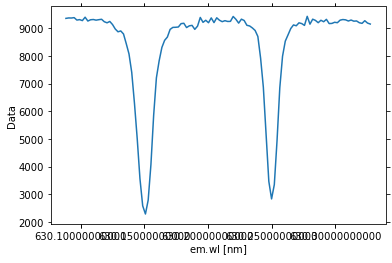

In [21]:
# Plot Stokes I for the (0, 0) pixel
level1_cube[0, :, 0, 0].plot(axes_units=['nm'])

<WCSAxesSubplot:>

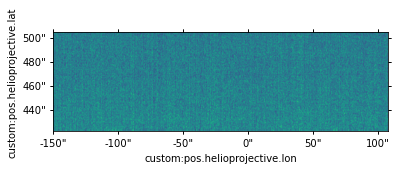

In [22]:
# Plot map Stokes I in the continuum
level1_cube[0, 0, :, :].plot()

<WCSAxesSubplot:>

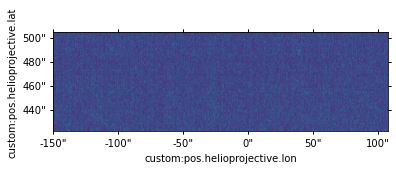

In [23]:
# Plot map of Stokes I in core
I_mean = np.mean(level1_cube[0].data, axis=(1,2)) # mean profile over map
ix_I_min = np.argmin(I_mean) # index of minimum of mean profile over map
level1_cube[0,int(ix_I_min), :, :].plot() # int() required; bug?

<WCSAxesSubplot:>

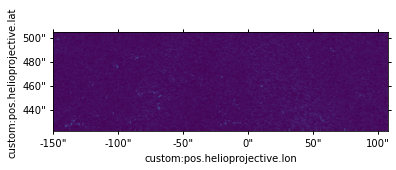

In [24]:
#Plot map of |B|
level2_cube[0, :, :].plot()

## GWCS

A different kind of WCS that supports distortions

In [25]:
from gwcs import coordinate_frames as cf
import astropy.units as u
sf = cf.StokesFrame()

assert sf.coordinates(0) == 'I'
assert sf.coordinates(0 * u.pix) == 'I'
assert sf.coordinate_to_quantity('I') == 0 * u.one
assert sf.coordinate_to_quantity(0) == 0